The goal of the experiment is to test whether the new push notification mechanics (group B) influences whether the user opens the app after receiving it.

# Stage 1. Primary data analysis

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy import stats

In [34]:
plt.figure(figsize=(20, 10))

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

1.1 Checking data completeness:

In [18]:
test = pd.read_csv('/content/ab_test_push_notifications.csv')
test.head(10)

,user_id,group,day,notification_sent_at,timestamp_open_app
0,user_0,B,2025-05-01,2025-05-01 15:41:00,NaN
1,user_1,B,2025-05-04,2025-05-04 10:53:00,NaN
2,user_2,A,2025-05-05,2025-05-05 16:15:00,NaN
3,user_3,A,2025-05-02,2025-05-02 18:24:00,NaN
4,user_4,B,2025-05-05,2025-05-05 12:19:00,NaN
5,user_5,B,2025-05-02,2025-05-02 15:17:00,NaN
6,user_6,A,2025-05-07,2025-05-07 15:21:00,2025-05-07 16:43:16.907028966
7,user_7,A,2025-05-02,2025-05-02 12:07:00,NaN
8,user_8,B,2025-05-07,2025-05-07 19:10:00,NaN
9,user_9,B,2025-05-05,2025-05-05 17:48:00,2025-05-05 18:25:50.829562552


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   user_id               1000 non-null   object
 1   group                 1000 non-null   object
 2   day                   1000 non-null   object
 3   notification_sent_at  1000 non-null   object
 4   timestamp_open_app    316 non-null    object
dtypes: object(5)
memory usage: 39.2+ KB


Missed `timestamp_open_app` indicates that the application was not opened on the test day. Let's create a binary feature that means 1 - application opened on this day, 0 - application did not open on this day.

In [20]:
test['opened_app'] = test['timestamp_open_app'].notna().astype(int)
test.head()

,user_id,group,day,notification_sent_at,timestamp_open_app,opened_app
0,user_0,B,2025-05-01,2025-05-01 15:41:00,NaN,0
1,user_1,B,2025-05-04,2025-05-04 10:53:00,NaN,0
2,user_2,A,2025-05-05,2025-05-05 16:15:00,NaN,0
3,user_3,A,2025-05-02,2025-05-02 18:24:00,NaN,0
4,user_4,B,2025-05-05,2025-05-05 12:19:00,NaN,0


In [21]:
#Change formats for timestamps
test['day'] = pd.to_datetime(test['day'])
test['timestamp_open_app'] = pd.to_datetime(test['timestamp_open_app'])
test['notification_sent_at'] = pd.to_datetime(test['notification_sent_at'])

In [22]:
#Add feature time reaction in mins

test['time_to_open'] = (test['timestamp_open_app'] - test['notification_sent_at']).dt.total_seconds()/60

In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               1000 non-null   object        
 1   group                 1000 non-null   object        
 2   day                   1000 non-null   datetime64[ns]
 3   notification_sent_at  1000 non-null   datetime64[ns]
 4   timestamp_open_app    316 non-null    datetime64[ns]
 5   opened_app            1000 non-null   int64         
 6   time_to_open          316 non-null    float64       
dtypes: datetime64[ns](3), float64(1), int64(1), object(2)
memory usage: 54.8+ KB


In [24]:
test.head()

,user_id,group,day,notification_sent_at,timestamp_open_app,opened_app,time_to_open
0,user_0,B,2025-05-01,2025-05-01 15:41:00,NaT,0,NaN
1,user_1,B,2025-05-04,2025-05-04 10:53:00,NaT,0,NaN
2,user_2,A,2025-05-05,2025-05-05 16:15:00,NaT,0,NaN
3,user_3,A,2025-05-02,2025-05-02 18:24:00,NaT,0,NaN
4,user_4,B,2025-05-05,2025-05-05 12:19:00,NaT,0,NaN


1.2 Checking the correctness of the distribution of users into groups:

In [27]:
# count unique users

test.user_id.nunique()

1000

In [28]:
#number of unique users in groups

test.groupby('group')['user_id'].nunique()

,user_id
group,
A,489
B,511


In [29]:
#number of unique users each day

users_by_days = test.groupby('day')['user_id'].nunique().reset_index()
users_by_days

,day,user_id
0,2025-05-01,130
1,2025-05-02,146
2,2025-05-03,147
3,2025-05-04,139
4,2025-05-05,154
5,2025-05-06,144
6,2025-05-07,140


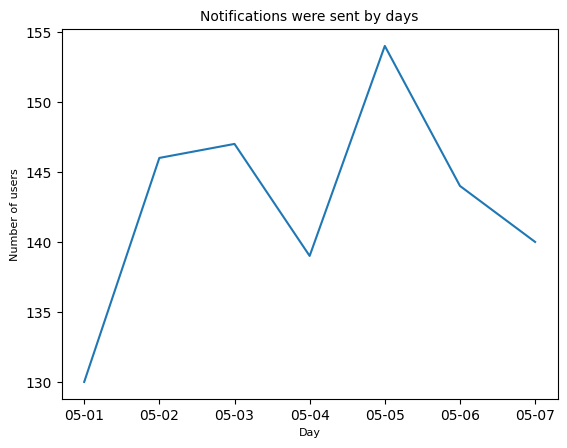

In [40]:
plt.plot(users_by_days['day'], users_by_days['user_id'])

plt.title("Notifications were sent by days", fontsize=10)
plt.xlabel("Day", fontsize=8)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylabel("Number of users", fontsize=8)
plt.show()

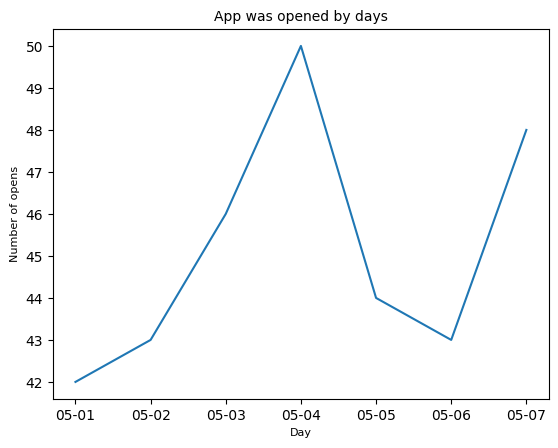

In [45]:
#App opens each day

opens_by_days = test.groupby('day')['opened_app'].sum().reset_index()

plt.plot(opens_by_days['day'], opens_by_days['opened_app'])

plt.title("App was opened by days", fontsize=10)
plt.xlabel("Day", fontsize=8)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylabel("Number of opens", fontsize=8)
plt.show()

The graph shows jumps on days 4 and 6. These observations are of interest for further study.

In [46]:
#Testing randomness using a Chi-square test
contingency_table = pd.crosstab(test['user_id'], test['group'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"P-value: {p}")

P-value: 0.48513148927490146


The Chi-square test was used to assess whether users were randomly assigned to groups A and B. The null hypothesis (H₀) assumes that the users are randomly distributed between the groups. With a p-value of 0.485, we fail to reject the null hypothesis, suggesting that the distribution of users between the two groups does not significantly differ from random assignment. This indicates that the users were likely assigned to groups in a random manner.

# Stage 2. Conversion analysis

In [50]:
total_A = test[test['group'] == 'A'].user_id.nunique()
total_B = test[test['group'] == 'B'].user_id.nunique()

print('Total in group A: ', total_A)
print('Total in group B: ', total_B)

Total in group A:  489
Total in group B:  511


In [52]:
opened_A = test[(test['group'] == 'A') & (test['opened_app'] == 1)].user_id.nunique()
opened_B = test[(test['group'] == 'B') & (test['opened_app'] == 1)].user_id.nunique()

print('Total in group A: ', opened_A)
print('Total in group B: ', opened_B)

Total in group A:  127
Total in group B:  189


In [55]:
conversion_A = opened_A/total_A
conversion_B = opened_B/total_B

print('Conversion in group A: ', round(conversion_A,2))
print('Conversion in group B: ', round(conversion_B,2))

Conversion in group A:  0.26
Conversion in group B:  0.37


We are going to use z-test and chi2 test to proportions comparing. Check еру conditions of applicability of tests

In [56]:
# Chi2-squared test require more then 5 cases in each category
test.groupby(['group', 'opened_app'])['user_id'].nunique()

group  opened_app
A      0             362
       1             127
B      0             322
       1             189
Name: user_id, dtype: int64

Hypothesis:

H0: Convertions are the same in groups A and B.

H1(alternative): Conversions are different.



In [57]:
from statsmodels.stats.proportion import proportions_ztest

In [58]:
successes = [opened_A, opened_B]
nobs = [total_A, total_B]
z_stat, p_value = proportions_ztest(count = successes, nobs = nobs)

print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_value:.4f}")

Z-statistic: -3.745
P-value: 0.0002


Since the p-value is significantly lower than the conventional threshold of 0.05, we reject the null hypothesis.

Conclusion: There is a **statistically significant difference** in conversion rates between the two groups.
Group B (new push notification mechanics) shows **a higher conversion**, suggesting that the change may have positively impacted user behavior.

# Stage 3. Analysis of time to opening

In [64]:
# Average time to opening
avg_time_to_opening = test.groupby('group')['time_to_open'].mean().reset_index()

<ipython-input-68-d5fa850982e3>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='time_to_open', data=test, palette="Set2")


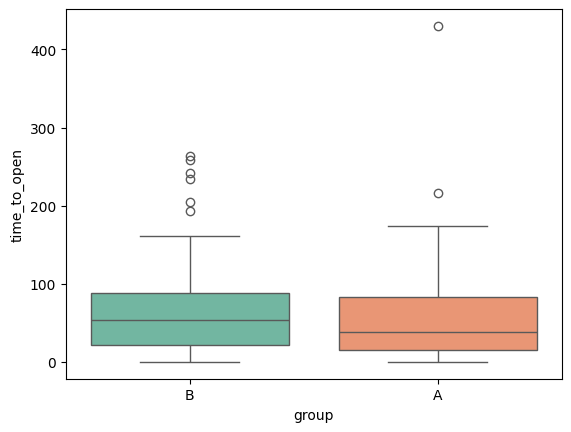

In [68]:
sns.boxplot(x='group', y='time_to_open', data=test, palette="Set2")
plt.show()

In [61]:
test.groupby('group')['time_to_open'].median()

,time_to_open
group,
A,38.876578
B,53.298192


Use Mann-Whitney U test to compare median of time opening in A and B groups.

H0: There is no difference in the distribution of time to open the app between group A and group B.

H1 (alternative): There is a difference in the distribution of time to open the app between group A and group B.

In [72]:
time_A = test[test['group'] == 'A']['time_to_open'].dropna()
time_B = test[test['group'] == 'B']['time_to_open'].dropna()

u_stat, p_value = stats.mannwhitneyu(time_A, time_B)
print(f"U-statistic: {u_stat:.3f}")
print(f"P-value: {p_value:.4f}")

U-statistic: 10485.000
P-value: 0.0569


Conclusion:
Based on the results of the Mann–Whitney U test (U = 10485.000, p = 0.0569), the difference in time to open the app between groups A and B **is not statistically significant** at the 0.05 level.
This suggests that **we do not have sufficient evidence** to conclude that the new push notification mechanic (group B) led to faster app openings compared to the control group.

# Stage 4. Dynamics by days of the experiment

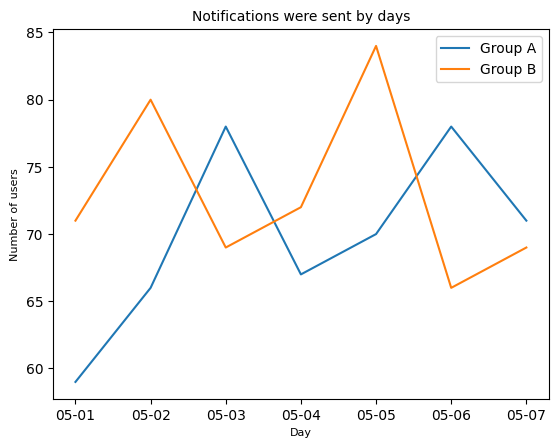

In [76]:
#Number of pushes every day

daily_counts = test.groupby(['day', 'group'])['user_id'].nunique().reset_index()
pivot_df = daily_counts.pivot(index='day', columns='group', values='user_id')

plt.plot(pivot_df.index, pivot_df['A'], label='Group A')
plt.plot(pivot_df.index, pivot_df['B'], label='Group B')

plt.title("Notifications were sent by days", fontsize=10)
plt.xlabel("Day", fontsize=8)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylabel("Number of users", fontsize=8)
plt.legend()
plt.show()

Overall, the number of notifications sent in both groups fluctuates between 60 and 85.

The smallest number of notifications in group B is May 5, which stands out from the other days.

The distribution by days is uneven, but the difference is not critical.

**Conclusions:**

The distribution of notifications is not perfectly even, but both groups received notifications every day.

May 5 is a spike in the number of notifications for group B, in contrast to May 4, where both groups had the fewest sendings.

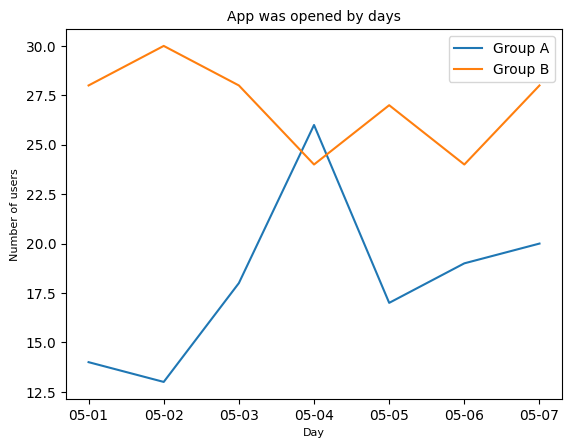

In [79]:
#Number of opens each day

daily_counts = test.groupby(['day', 'group'])['opened_app'].sum().reset_index()
pivot_df = daily_counts.pivot(index='day', columns='group', values='opened_app')

plt.plot(pivot_df.index, pivot_df['A'], label='Group A')
plt.plot(pivot_df.index, pivot_df['B'], label='Group B')

plt.title("App was opened by days", fontsize=10)
plt.xlabel("Day", fontsize=8)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylabel("Number of users", fontsize=8)
plt.legend()
plt.show()

**Unusual behavior:**

May 4:
Group A — a sharp spike in opens against the backdrop of a decrease in the number of notifications.

Group B — a noticeable decrease in opens, despite the usual number of notifications sent.

Possible explanation: specific user activity in group A on this day (e.g. an external factor, coincidence, a bug in the simulation).

May 5:
Group B received the maximum number of notifications and simultaneously showed the maximum number of opens, which is expected.

**Conclusion:**
Overall, group B shows more stable and higher open values, which confirms the positive effect of the new push notification mechanics.

May 4 requires attention: group A suddenly showed the best result in opens. This may be a coincidence or a result of instability in the data.

Despite the uneven number of sendings, on average, group B wins, especially in conversion and daily activity.

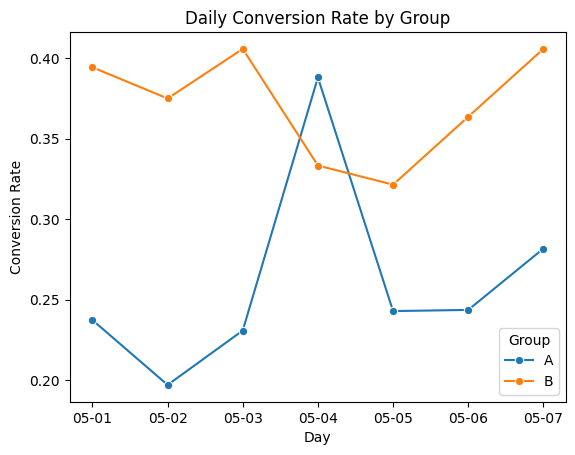

In [83]:
#Conversion daily dynamic

daily_total = test.groupby(['day', 'group'])['user_id'].count().reset_index(name='total')
daily_opened = test[test['timestamp_open_app'].notna()] \
                  .groupby(['day', 'group'])['user_id'].count().reset_index(name='opened')

daily_stats = pd.merge(daily_total, daily_opened, on=['day', 'group'], how='left')
daily_stats['opened'] = daily_stats['opened'].fillna(0)
daily_stats['conversion'] = daily_stats['opened'] / daily_stats['total']

sns.lineplot(data=daily_stats, x='day', y='conversion', hue='group', marker='o')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


plt.title('Daily Conversion Rate by Group')
plt.xlabel('Day')
plt.ylabel('Conversion Rate')
plt.legend(title='Group')

plt.show()

The days off were May 3 and 4. Since the jump was observed only in group A and only on 1 day, no additional study was conducted by days of the week.

# Stage 5: Conclusions & Recommendations

**Overall conclusions:**

*Conversion:* The new push notification mechanics in Group B showed a statistically significant improvement compared to Control Group A.

*Time to open:* The difference in time to open the app between the groups is not statistically significant, indicating that the new notification mechanics did not affect the speed of opening the app.

*Daily dynamics:* There is normal variability in conversion, with minor peaks, which is common and does not indicate significant changes in user behavior.

**Recommendations:**
Based on the test results, the new notification mechanics (Group B) increases conversion. This may be an important factor for further implementation and scaling of notifications in the app.

Time to open did not change significantly, indicating that the change in notification mechanics did not affect the speed of user reaction, meaning that the new notification method does not create delays in user actions.